In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.linalg as LA
import pandas as pd

In [2]:
import Function as f

In [3]:
absdd = np.array([1,-1,-1,1,1,-1,-1,-1,1,-1])[:,np.newaxis].T
print(absdd.shape)
print(f.Weighted_Ages(absdd))

(1, 10)
[4.333333333333333]


In [4]:
np.random.seed(1000)

Hyper parameter

In [5]:
max_iteration = 15000
weight_decay = 1e-5
Epsilons = [10,10]
BANDWIDTH = 0.5

In [6]:
filename = "1000(900+100).csv"
(X, X_train, X_val), (Y, Y_train, Y_val), (survival_times)= f.read_files(filename)
NUM_TRAIN = X_train.shape[0]
NUM_VAL = X_val.shape[0]
NUM_EMPLOYEES = X.shape[0]

[  5.  11.   2. 100.  61. 155.  15. 147.  61.  17. 121.   1.  61. 106.
  34.  37.  14.  28.  50.  31.  10.  13.   1.  72.  17.  28.  89.   7.
  83.   2.  57.  13.  51.  32.  13. 141.   7. 102.   2.  60.  43. 103.
  13.  11.  18.  46.  12.  10.  59.  88.  12.  17.  28.  51. 111.   4.
  80.  26.  26.   5.   1.  29.   8.  22.  94.  12.  10.   6.   1.  27.
   9. 141.   4.  21.   9. 100.  20.  63.  41.  67.   6.  89.  34.   7.
  50.  33.  25.   3.  10.  26.  80.  15.   7.  29.  70.   1. 108.  85.
  80.  38.  34.   1.  11.  58.   2.  23.  55. 174.  29.   6.  15.  78.
   8.   1.   1.  71.  15.  27.  24.  37.  66.  22.  29.  92.  30. 113.
  97.  12.  34.  22.   1.   5. 142. 123.  10.   4. 102.  26.   9.  27.
   1.  50.  13.  15.  58.  60.  12.  26.  22.  10.  28. 106.   9. 123.
  91.  40.   6.  96.   7.  26.  92.  33.   1.   6.  37.   8.  15.  70.
   6.   2.  10.  10. 121. 183. 120.  16. 119. 114.  65.  76.  55.  55.
  18.  11.  70.   2.   3.  13. 122.   1.  10.   3. 120.  87.   1.  20.
  27. 

In [7]:
# Kernel_Matrix = f.Generating_Kernel(X, "Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix = f.Generating_Kernel(X, "Quick_Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix_Train = Kernel_Matrix[:NUM_TRAIN,:NUM_TRAIN]
Kernel_Matrix_Val = Kernel_Matrix[NUM_TRAIN:,:NUM_TRAIN]

The Stochastic sub-Gradient Descent is shown below

There are  989330 pairs of samples of similarity between 0.0 and 0.1 which have an average age_gap  44.9657222564766 and the median is: 32.0
There are  5336 pairs of samples of similarity between 0.1 and 0.2 which have an average age_gap  30.12143928035982 and the median is: 19.0
There are  2182 pairs of samples of similarity between 0.2 and 0.3 which have an average age_gap  28.998166819431713 and the median is: 19.0
There are  1070 pairs of samples of similarity between 0.3 and 0.4 which have an average age_gap  28.885981308411214 and the median is: 19.0
There are  554 pairs of samples of similarity between 0.4 and 0.5 which have an average age_gap  26.859205776173287 and the median is: 17.0
There are  248 pairs of samples of similarity between 0.5 and 0.6 which have an average age_gap  26.201612903225808 and the median is: 16.0
There are  162 pairs of samples of similarity between 0.6 and 0.7 which have an average age_gap  26.91358024691358 and the median is: 21.0
There are  92 pair

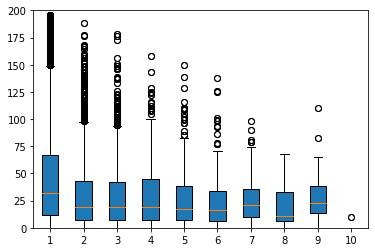

In [8]:
f.Validate_Synthetic_DataSet(Kernel_Matrix, survival_times)

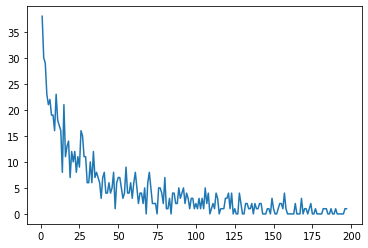

In [9]:
NUM_TASKS = Y.shape[1]
x_axis = np.arange(NUM_TASKS)+1
y_train_gt_axis = np.zeros(NUM_TASKS)
for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis)

In [10]:
print(NUM_TASKS)
## DEL TOP 5%

197


In [11]:
alpha = np.zeros_like(Y_train)
beta = np.zeros((NUM_TRAIN,NUM_TASKS,NUM_TASKS))
for t in range(1, max_iteration + 1):
    alpha, beta = f.new_C2(Kernel_Matrix_Train, Y_train, alpha, beta, 1, t, weight_decay)
    
    if t%500 == 0: 
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha*Y_train) 
        for i in range(NUM_TRAIN):
            hstack_M_K_i = Kernel_Matrix_Train[i].repeat(NUM_TASKS).reshape(NUM_TRAIN, NUM_TASKS)
            hatY_train += hstack_M_K_i.dot(beta[i, :, :])
        hatY_train /= ( t * weight_decay )
        
        hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) 
        for i in range(NUM_TRAIN):
            hstack_M_K_i = Kernel_Matrix_Val[:,i].repeat(NUM_TASKS).reshape(NUM_VAL, NUM_TASKS)
            hatY_val += hstack_M_K_i.dot(beta[i, :, :])
        hatY_val /= ( t * weight_decay )
        
        predict_age_tr = f.Weighted_Ages(hatY_train)
        predict_age_val = f.Weighted_Ages(hatY_val)
        predict_age = predict_age_tr + predict_age_val
            
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * NUM_TASKS)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * NUM_TASKS)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        # C_index_tr = f.Calculate_C_index(survival_times[:NUM_TRAIN], predict_age_tr)
        C_index_val = f.Calculate_C_index(survival_times[NUM_TRAIN:], predict_age_val)
         
        # print("the c-index for training is:", C_index_tr)xx
        print("the c-index for val is:", C_index_val)

the iteration is: 500


/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the train accuracy is: 0.8504624929498026
the val accuracy is: 0.7885279187817259
2743 4869.0
the c-index for val is: 0.563360032860957
the iteration is: 1000
the train accuracy is: 0.9106486181613085
the val accuracy is: 0.7967005076142132
2716 4869.0
the c-index for val is: 0.5578147463544876
the iteration is: 1500
the train accuracy is: 0.9425549915397631
the val accuracy is: 0.8034010152284264
2748 4869.0
the c-index for val is: 0.5643869377695625
the iteration is: 2000
the train accuracy is: 0.9573040045121264
the val accuracy is: 0.8143147208121827
2960 4869.0
the c-index for val is: 0.6079277058944341
the iteration is: 2500
the train accuracy is: 0.9698477157360406
the val accuracy is: 0.8018781725888325
2895 4869.0
the c-index for val is: 0.5945779420825632
the iteration is: 3000
the train accuracy is: 0.9805019740552735
the val accuracy is: 0.8112182741116751
2927 4869.0
the c-index for val is: 0.6011501334976381
the iteration is: 3500
the train accuracy is: 0.9857473209249858

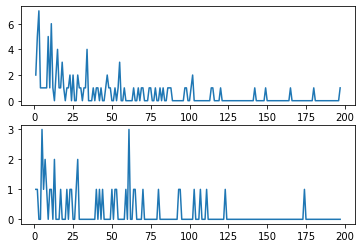

In [12]:
x_axis = np.arange(NUM_TASKS)+1 # the x axis
y_train_gt_axis = np.zeros(NUM_TASKS) # the ground truth train axis
y_val_gt_axis = np.zeros(NUM_TASKS) # the groud truth validation axis 
y_train_predict_axis = np.zeros(NUM_TASKS) # the predict train axis 
y_val_predict_axis = np.zeros(NUM_TASKS) # the predict validation axis 

for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
# plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis) # the training set: ground truth vs predict situation
# plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis) # the valiadtion set: ground truth vs predictsituation
plt.subplot(211)
plt.plot(x_axis, y_val_gt_axis)
plt.subplot(212)
plt.plot(x_axis, y_val_predict_axis)
# plt.plot(x_axis,y_train_predict_axis,y_val_predict_axis)

In [13]:
print(predict_age[NUM_TRAIN:])
print(survival_times[NUM_TRAIN:])
print(np.sum(predict_age[NUM_TRAIN:] > survival_times[NUM_TRAIN:]))
print(np.sum(predict_age[NUM_TRAIN:] < survival_times[NUM_TRAIN:]))
print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:]))

[95.57391304347826, 7.0, 5.0, 48.516129032258064, 44.89247311827957, 76.453125, 80.0, 37.02824858757062, 111.0, 43.98051948051948, 57.57615894039735, 73.78225806451613, 107.0, 67.3975155279503, 61.0, 64.0, 5.0, 75.95428571428572, 33.67058823529412, 50.0, 49.38461538461539, 34.75, 27.0, 33.87951807228916, 24.0, 48.56, 16.752688172043012, 111.23595505617978, 52.04494382022472, 73.64, 13.0, 23.705263157894738, 40.0, 61.0, 61.0, 174.0, 42.0, 7.0, 89.98148148148148, 94.0, 71.87786259541984, 100.07692307692308, 21.0, 1.0, 32.130434782608695, 32.56544502617801, 63.44827586206897, 56.65217391304348, 93.0, 5.0, 36.047904191616766, 26.94736842105263, 23.0, 53.0, 63.96268656716418, 10.0, 10.97860962566845, 38.90683229813665, 52.712574850299404, 66.9877300613497, 72.54838709677419, 60.8705035971223, 28.0, 17.805405405405406, 21.774193548387096, 17.0, 67.66666666666667, 103.0, 65.0, 28.0, 12.989189189189188, 67.25925925925925, 70.0, 33.19101123595506, 57.172413793103445, 40.61490683229814, 67.06206

In [14]:
hatY_train =  Kernel_Matrix_Train.dot(alpha*Y_train) / (max_iteration * weight_decay )

In [15]:
hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) / (max_iteration * weight_decay )

In [16]:
hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) 
for i in range(NUM_TRAIN):
    hstack_M_K_i = Kernel_Matrix_Val[:,i].repeat(NUM_TASKS).reshape(NUM_VAL, NUM_TASKS)
    hatY_val += hstack_M_K_i.dot(beta[i, :, :])
hatY_val /= ( max_iteration * weight_decay )


In [17]:
hatY_train =  Kernel_Matrix_Train.dot(alpha*Y_train) 
for i in range(NUM_TRAIN):
    hstack_M_K_i = Kernel_Matrix_Train[:,i].repeat(NUM_TASKS).reshape(NUM_TRAIN, NUM_TASKS)
    hatY_val += hstack_M_K_i.dot(beta[i, :, :])
hatY_val /= ( max_iteration * weight_decay )



ValueError: operands could not be broadcast together with shapes (100,197) (900,197) (100,197) 

In [ ]:
violate = 0
for i in range(NUM_TRAIN):
    if np.argwhere(hatY_train[i] < 0) != []:
        minus_list = np.argwhere(hatY_train[i] < 0)
        first_minus = minus_list[0]
        after_pos_list = np.argwhere(hatY_train[i, first_minus:] > 0)
        # print(after_pos_list)
        if len(after_pos_list):
            # print(after_pos_list)
            violate += 1

print(violate)
print(NUM_TRAIN)
# print(survival_times[-NUM_VAL])

In [ ]:
violate = 0
for i in range(NUM_VAL):
    if np.argwhere(hatY_val[i] < 0) != []:
        minus_list = np.argwhere(hatY_val[i] < 0)
        first_minus = minus_list[0]
        after_pos_list = np.argwhere(hatY_val[i, first_minus:] > 0)
        if len(after_pos_list):
            # print(after_pos_list)
            violate += 1

print(violate)
print(NUM_VAL)
# print(survival_times[-NUM_VAL])


In [ ]:
print(hatY_val)

In [ ]:
validation_age = predict_age[NUM_TRAIN:]
tr_age = predict_age[:NUM_TRAIN]
train_vs_validation_samples = Kernel_Matrix[:NUM_TRAIN,NUM_TRAIN:]
train_vs_train_samples = Kernel_Matrix_Train
train_id = 11
plt.xlim(0,1)
age_gap_list = np.zeros(100)
num_list = np.zeros(100)
for i in range(NUM_TRAIN):
    for j in range(NUM_VAL):
        interval_id = np.int(np.floor((train_vs_validation_samples[i,j] / 0.01)))
        age_gap = abs(validation_age[j] - tr_age[i])
        age_gap_list[interval_id] += age_gap
        num_list += 1
avg_age_gap_list = age_gap_list/num_list
plt.plot(np.linspace(0,1, num = 100),avg_age_gap_list)
# plt.scatter(np.linspace(0,1, num = 100), avg_age_gap_list)
# plt.scatter(train_vs_train_samples[train_id],abs(tr_age-survival_times[train_id]))
# plt.scatter(train_vs_validation_samples[train_id], abs(validation_age-survival_times[train_id]))
# print(train_vs_validation_samples[train_id])